# Model Training

### Load the ABT

In [1]:
# NumPy for numerical computing
import numpy as np
# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)
# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline
# Seaborn for easier visualization
import seaborn as sns
# Scikit-Learn for Modeling
import sklearn
# Pickle for saving model files
import pickle

In [2]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression
# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
# Function for splitting training and test set
from sklearn.model_selection import train_test_split
# Function for creating model pipelines
from sklearn.pipeline import make_pipeline 
# For standardization
from sklearn.preprocessing import StandardScaler
# Helper for cross-validation
from sklearn.model_selection import GridSearchCV
# Classification metrics
from sklearn.metrics import roc_curve, auc

In [4]:
df = pd.read_csv('analytical_base_table.csv')
df.head()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,last_evaluation_missing,underperformer,unhappy,overachiever,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0


### Split the dataset

In [5]:
y = df.status
X = df.drop('status', axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1234,
                                                    stratify=df.status)

print( len(X_train), len(X_test), len(y_train), len(y_test) )

11254 2814 11254 2814


### Build model pipelines

In [7]:
pipe = {
    'l1' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l1' , random_state=123)),
    'l2' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l2' , random_state=123)),
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
}

### Declare hyperparams

In [8]:
l1_h = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
}

l2_h = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
}

rf_h = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]
}

gb_h = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

hyperparams = {
    'l1' : l1_h,
    'l2' : l2_h,
    'rf' : rf_h,
    'gb' : gb_h
}

### Model fitting

In [9]:
fitted_models = {}

for name, pipeline in pipe.items():
    model = GridSearchCV(pipeline, hyperparams[name], cv=10, n_jobs=-1)
    model.fit(X_train, y_train) 
    fitted_models[name] = model
    print(name, 'has been fitted.')

l1 has been fitted.
l2 has been fitted.
rf has been fitted.
gb has been fitted.


### Evaluate metrics

In [10]:
# best_score_ for each fitted model
for name, model in fitted_models.items():
    print( name, model.best_score_ )

l1 0.849386884663
l2 0.849386884663
rf 0.979651679403
gb 0.975208814644


### AUC

In [11]:
for name, model in fitted_models.items():
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    print( name, auc(fpr, tpr) )

l1 0.901539531388
l2 0.901538837374
rf 0.991520189216
gb 0.988680283685


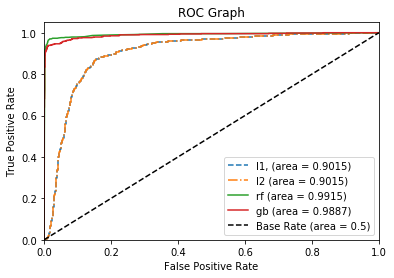

In [12]:
# Create ROC Graph
fpr, tpr, thresholds = roc_curve(y_test, fitted_models['l1'].predict_proba(X_test)[:,1])
l2_fpr, l2_tpr, l2_thresholds = roc_curve(y_test, fitted_models['l2'].predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, fitted_models['rf'].predict_proba(X_test)[:,1])
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_test, fitted_models['gb'].predict_proba(X_test)[:,1])

plt.figure()

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, '--', label='l1, (area = %0.4f)' % auc(fpr, tpr))

# Plot Random Forest ROC
plt.plot(l2_fpr, l2_tpr,'-.', label='l2 (area = %0.4f)' % auc(l2_fpr, l2_tpr))

# Plot Decision Tree ROC
plt.plot(rf_fpr, rf_tpr, label='rf (area = %0.4f)' % auc(rf_fpr, rf_tpr))

# Plot AdaBoost ROC
plt.plot(gb_fpr, gb_tpr, label='gb (area = %0.4f)' % auc(gb_fpr, gb_tpr))

# Plot Base Rate ROC
plt.plot([0,1], [0,1], 'k--', label='Base Rate' ' (area = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

Based on the metrics, the best model is the random forest.

### Feature importance of the winning model, Random Forest:

In [13]:
pipe['rf']

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...timators=10, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False))])

In [14]:
rf_feat = fitted_models['rf'].best_estimator_.named_steps['randomforestclassifier'].feature_importances_

# random forest
importance = pd.DataFrame(list(zip(X.columns, np.transpose(rf_feat))) \
            ).sort_values(1, ascending=False)
importance

,0,1
5,satisfaction,0.232962
3,n_projects,0.210147
6,tenure,0.177673
0,avg_monthly_hrs,0.164821
2,last_evaluation,0.089156
10,overachiever,0.046118
9,unhappy,0.033068
8,underperformer,0.007951
1,filed_complaint,0.005457
23,salary_low,0.005082


Based on the best model, the top 5 indicators of the status of an employee are satisfaction, n_projects, tenure, avg_monthly_hrs, and last_evaluation.

### Coefficients of the l2 Logistic Regression Model:

In [15]:
pipe['l2']

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [16]:
l2_feat = fitted_models['l2'].best_estimator_.named_steps['logisticregression'].coef_

importance = pd.DataFrame(list(zip(X.columns, np.transpose(l2_feat))) \
            ).sort_values(1, ascending=False)
importance

,0,1
10,overachiever,[1.477095051]
7,last_evaluation_missing,[1.47697466111]
8,underperformer,[1.37799500145]
2,last_evaluation,[1.11926845365]
6,tenure,[0.368054175043]
0,avg_monthly_hrs,[0.318916066353]
23,salary_low,[0.225953109488]
9,unhappy,[0.104904806454]
12,department_Missing,[0.0618337918376]
14,department_engineering,[0.0465071194158]


### Save the final model.

In [17]:
with open('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)